In [9]:
! pip install matplotlib

    100% |████████████████████████████████| 13.7MB 3.2MB/s ta 0:00:011
    100% |████████████████████████████████| 512kB 6.4MB/s ta 0:00:01
    100% |████████████████████████████████| 112kB 7.7MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 6.6MB/s ta 0:00:011


In [10]:
import shutil
import pickle
import numpy as np
from collections import Counter
from hashlib import sha512
from string import ascii_letters
from tqdm import tqdm_notebook
from utils import Tokenizer
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
p_raw_text = './data/raw_text.txt'
p_filtered_text = './data/filtered_text.txt'
p_word_vectors = './data/word_vectors.npy'
p_file_idxes = 'data/file_idxes.npy'
p_tokenizer = 'data/tokenizer.pickle'
p_label2idx = 'data/label2idx.pickle'
p_label_counter = 'data/label_counter'
p_word2vec = 'data/word2vec.npy'
data_path = './data'
fields_delimetr = '\t\t'
labels_delimetr = '##'

In [12]:
N_SPLITS = 4# 40
LABEL_COUNT_THRESHOLD = 0
EMBEDDING_DIM = 200
FILES_IN_FOLDER = 5# 3000
WORDS_IN_BATCH = 350# 350 * 64
MAX_BATCH_SIZE = 100# 256
N_WORDS = 1500

    Make fake raw texts and word vectors

In [13]:
letter_list = list(ascii_letters)
def generate_word():
    word_len = np.random.randint(3, 7)
    return ''.join(np.random.choice(letter_list, word_len))

def generate_sentence():
    sent_len = np.random.binomial(10, 0.5) + 1
    return ' '.join([generate_word() for _ in range(sent_len)]) + '.'

def generate_text():
    sent_number = np.random.binomial(5, 0.5) + 1
    return ' '.join([generate_sentence() for _ in range(sent_number)])

generate_text()

'xJdW bCuCq BIaRPl vhXE XeNrVf. hhpCZs xeCmht Vzy fMWSCe FVkXAH iuWfR OcZuhq HdVzx Nmwjed DxTZRP. ivIx iKKpk xqR VuO yvHAGK kxRjsH ZExqd BRgLc.'

In [14]:
with open(p_raw_text, 'w') as fraw:
    for i in tqdm_notebook(range(5000)):
        labels = labels_delimetr.join([generate_word() for _ in range(3)])
        text, title = generate_text(), generate_sentence()
        fraw.write(fields_delimetr.join([labels, title, text]) + '\n')

In [15]:
with open(p_word_vectors, 'w') as fwv:
    for i in tqdm_notebook(range(10000)):
        word = generate_word().lower()
        vec = np.random.randn(200)
        fwv.write('\t'.join([word, ' '.join(vec.astype('float32').astype(str))]) + '\n')

    Reading

In [16]:
def get_hash(text):
    return sha512(text.encode()).hexdigest()

hash_set = set()
filtered_texts, filtered_labels = [], []
with open(p_raw_text, 'r') as fraw:
    for line in tqdm_notebook(fraw, desc='read raw'):
        line = line.replace('\n', '').lower().strip()
        labels, title, text = line.split(fields_delimetr)
        text_hash = get_hash(text)
        if text_hash not in hash_set:
            hash_set.add(text_hash)
            filtered_texts.append(' '.join([title, text]))
            filtered_labels.append(labels)

    Make label2idx

In [17]:
label_counter = Counter()
for label_line in tqdm_notebook(filtered_labels, desc='updating label counter'):
    label_counter.update(label_line.split(labels_delimetr))
label2idx = {label: idx for idx, (label, count) in enumerate(label_counter.most_common())
             if count >= LABEL_COUNT_THRESHOLD}
label_counter.most_common(1)

[('pab', 4)]

    Tokenize and collect words in tokenizer

In [18]:
tokenizer = Tokenizer()
lens = np.array([len(tokenizer.tokenize(t, update_words=True))
                 for t in tqdm_notebook(filtered_texts, desc='tokenizing')])

    Merge tokenizer with word vectors

In [19]:
len(tokenizer.word_count)

115307

In [20]:
word2vec = {}
with open(p_word_vectors, 'r') as fwv:
    for line in tqdm_notebook(fwv, desc='read vectors'):
        word, vec = line.strip().split('\t')
        word2vec[word] = vec
words2remove = set()
for word in tqdm_notebook(tokenizer.word_count, desc='looking for words to remove'):
    if word not in word2vec:
        words2remove.add(word)
for word in tqdm_notebook(words2remove, desc='removing words'):
    tokenizer.word2idx.pop(word)
    tokenizer.word_count.pop(word)

In [21]:
len(tokenizer.word_count)

2090

In [22]:
tokenizer.shrink(N_WORDS)
len(tokenizer.word_count)

1500

    Make padded lens from lens

In [23]:
def get_pad_lens(lens, n_splits=40):
    percentiles = np.percentile(lens, np.linspace(0, 100, n_splits + 1)[1:]).astype('int')
    sorted_pad_lens = np.sort(percentiles)
    percentiles = np.repeat([percentiles], len(lens), axis=0)
    return sorted_pad_lens[np.argmax(np.greater_equal(percentiles, lens.reshape(-1, 1)), axis=1)]

In [24]:
pad_lens = get_pad_lens(lens, n_splits=N_SPLITS)

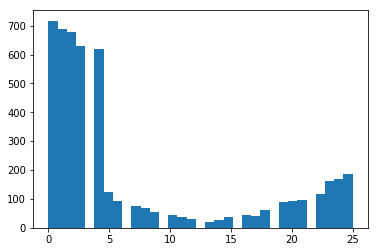

In [25]:
h = plt.hist(pad_lens - lens, bins=33)

In [26]:
unique_pad_lens = np.unique(pad_lens)

    Make dict from pad_len to text idxes

In [27]:
pad_len2idxes = {}
for pad_len in unique_pad_lens:
    pad_len2idxes[pad_len] = np.arange(len(filtered_texts))[pad_lens==pad_len]
    np.random.shuffle(pad_len2idxes[pad_len])

    Functions to write batches in format:
    - data_path
        - len{pad_len}
            - {number_of_dir_inside_batches_with_such_len}
                - {idx_of_batch}
    Inside file:
    {label1}##{label_2}##...##{label_n}\t\t{word_1_idx} {word_2_idx} ... {word_m_idx}

In [28]:
def write_batch(batch, path):
    with open(path, 'w') as f:
        for idx in batch:
            f.write('\t'.join([
                filtered_labels[idx],
                ' '.join(map(str, tokenizer.tokenize(filtered_texts[idx])))
            ]) + '\n')


def get_dir_path(path, *idxes):
    return shutil.os.path.join(path, *map(str, idxes))


def write_batches(idxes, path, batch_size):
    dir_idx = 0
    shutil.os.mkdir(get_dir_path(path, dir_idx))
    for batch_idx, start_idx in tqdm_notebook(enumerate(range(0, len(idxes), batch_size)), desc=path):
        end_idx = min(start_idx + batch_size, len(idxes))
        if len(shutil.os.listdir(get_dir_path(path, dir_idx))) == FILES_IN_FOLDER:
            dir_idx += 1
            shutil.os.mkdir(get_dir_path(path, dir_idx))
        write_batch(idxes[start_idx : end_idx], get_dir_path(path, dir_idx, batch_idx))

In [29]:
! ls data/

raw_text.txt     word_vectors.npy


    Drop old dirs

In [22]:
for dir_name in shutil.os.listdir(data_path):
    if dir_name.startswith('len'):
        shutil.rmtree(shutil.os.path.join(data_path, dir_name))

In [23]:
! ls data/

file_idxes.npy   label_counter    tokenizer.pickle word_vectors.npy
label2idx.pickle raw_text.txt     word_vectors


    Make writing

In [24]:
for pad_len, idxes in pad_len2idxes.items():
    path = shutil.os.path.join('./data/', 'len' + str(pad_len))
    shutil.os.mkdir(path)
    write_batches(idxes, path, min(MAX_BATCH_SIZE, WORDS_IN_BATCH // pad_len))

    Look at lens histogram

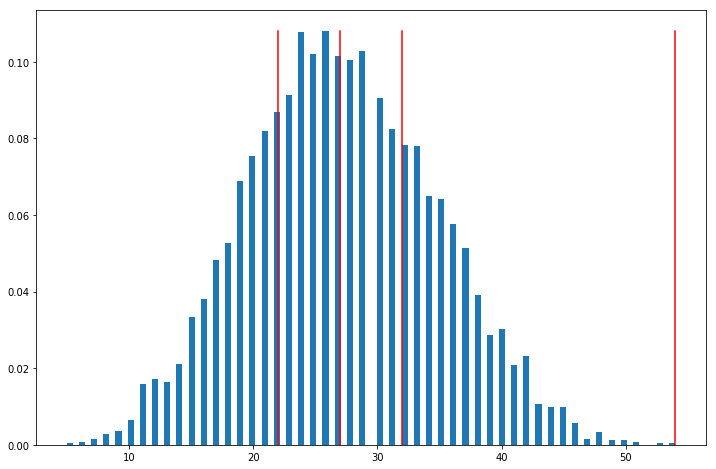

In [25]:
fig, ax = plt.subplots(figsize=[12, 8])
d = ax.hist(lens, bins=100, density=True)
for l in unique_pad_lens:
    ax.plot([l, l], [0, max(d[0])], c='r')

In [26]:
pad_len2size = {pad_len: len(idxes) for pad_len, idxes in pad_len2idxes.items()}

    Prepare paths for reading:
    file_idxes contains [{pad_len}, {dir_number}, {batch_number}]

In [27]:
file_idxes = []
for pad_len in unique_pad_lens:
    pad_len_dir = shutil.os.path.join(data_path, 'len' + str(pad_len))
    for dir_name in shutil.os.listdir(pad_len_dir):
        for file_name in shutil.os.listdir(shutil.os.path.join(pad_len_dir, dir_name)):
            file_idxes.append([pad_len, int(dir_name), int(file_name)])
file_idxes = np.array(file_idxes)
np.random.shuffle(file_idxes)

In [28]:
from tensorflow import keras
pad_sequences = keras.preprocessing.sequence.pad_sequences

In [29]:
def read_batch(data_path, batch_idxes):
    path = shutil.os.path.join(data_path, 'len' + str(batch_idxes[0]), *map(str, batch_idxes[1:]))
    sequences, label_idxes = [], []
    with open(path, 'r') as f:
        for line in f:
            try:
                label_set, text = line.strip().split('\t', 1)
                label_set = label_set.split(labels_delimetr)
                label_set = [label2idx[l] for l in label_set]
                label_idxes.append(label_set)
                sequences.append(list(map(int, text.split())))
            except:
                pass
    result_labels = np.zeros([len(sequences), len(label2idx)], dtype='int')
    for i, label_list in enumerate(label_idxes):
        result_labels[i, label_list] = 1
    return pad_sequences(sequences) if len(sequences) > 0 else np.array([[]]), result_labels

In [30]:
def generator(file_idxes, data_path):
    for file_idx in file_idxes:
        yield read_batch(data_path, file_idx)

In [31]:
word_vectors = np.zeros([len(tokenizer.word2idx), EMBEDDING_DIM], dtype='float32')
for word, idx in tokenizer.word2idx.items():
    if idx != 0:
        word_vectors[idx] = np.random.randn(200)# word2vec[word]

In [32]:
for i, (seq, lab) in enumerate(generator(file_idxes, data_path)):
    print(i, seq, lab)
    break

0 [[793]
 [705]
 [204]
 [285]] [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [33]:
np.save(p_file_idxes, file_idxes)
np.save(p_word_vectors, word_vectors)
with open(p_label2idx, 'wb') as f:
    pickle.dump(label2idx, f)
with open(p_label_counter, 'wb') as f:
    pickle.dump(label_counter, f)
with open(p_tokenizer, 'wb') as f:
    pickle.dump(tokenizer, f)

In [34]:
! ls data

file_idxes.npy   len22            len54            word_vectors
label2idx.pickle len27            raw_text.txt     word_vectors.npy
label_counter    len32            tokenizer.pickle


In [35]:
file_idxes = np.load(p_file_idxes)
word_vectors = np.load(p_word_vectors)
with open(p_label2idx, 'rb') as f:
    label2idx = pickle.load(f)
with open(p_label_counter, 'rb') as f:
    label_counter = pickle.load(f)
with open(p_tokenizer, 'rb') as f:
    tokenizer = pickle.load(f)